In [20]:
import pandas as pd 
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import tensorflow as tf

csvfile = "Data_training.csv"  #file name 

In [21]:
data_test= pd.read_csv(csvfile)
data_test.head()

,Episode,Kick_Speed,friction,Rewards,Stop_Distance
0,0,27.49,0.9,-281.07,80.07
1,1,36.35,0.9,-190.46,63.37
2,2,30.98,0.9,-302.92,76.42
3,3,44.88,0.9,-142.58,54.20
4,4,39.54,0.9,-161.63,61.00


In [67]:
profile = ProfileReport(data_test, minimal=True)
profile.to_file(output_file="output.html")

In [22]:
failed = data_test[data_test['Stop_Distance'] <= 0]
passed = data_test[data_test['Stop_Distance'] >0]

print('Size of crashes :',failed.shape[0])  
print('Size of success :',passed.shape[0]) 
print("Percentage of crash cases:{:.2f}".format(failed.shape[0]*100/(failed.shape[0]+passed.shape[0])),"%")
print("Percentage of not crashed cases:{:.2f}".format(passed.shape[0]*100/(failed.shape[0]+passed.shape[0])),"%")

failed.to_csv("crashed.csv",index=False)
failed.head()

Size of crashes : 136
Size of success : 2865
Percentage of crash cases:4.53 %
Percentage of not crashed cases:95.47 %


,Episode,Kick_Speed,friction,Rewards,Stop_Distance
111,111,67.39,0.9,-1042.58,-10.00
227,227,68.82,0.9,-1054.33,-10.09
265,265,81.44,0.9,-1095.60,-10.62
323,323,68.46,0.9,-1055.98,-10.32
429,429,71.23,0.9,-1070.38,-10.53


In [23]:
#passed.to_csv("not_crashed.csv",index=False  )
#passed.head()

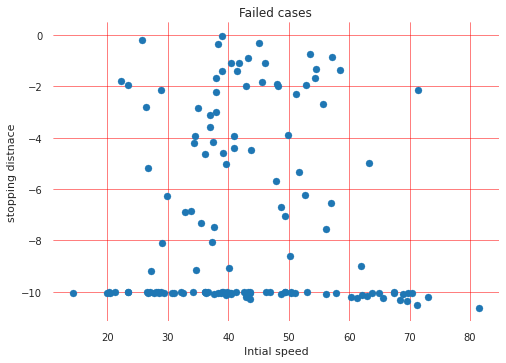

In [24]:
fig=plt.figure
plt.scatter(failed["Kick_Speed"],failed["Stop_Distance"],label='Line 2')
plt.grid(color='r', linestyle='-', linewidth=0.5)
plt.title("Failed cases")
plt.xlabel("Intial speed")
plt.ylabel("stopping distnace")
plt.show()

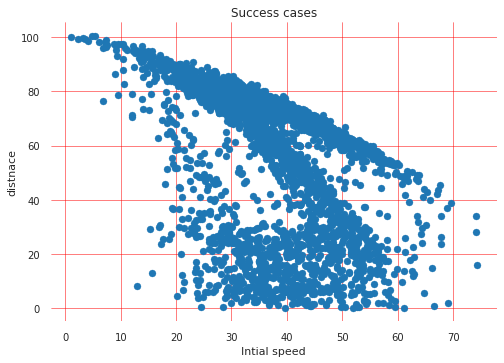

In [25]:
fig=plt.figure
plt.scatter(passed["Kick_Speed"],passed["Stop_Distance"])
plt.grid(color='r', linestyle='-', linewidth=0.5)
plt.title("Success cases")
plt.xlabel("Intial speed")
plt.ylabel("distnace")
plt.show()


In [26]:
data_test.loc[data_test['Stop_Distance'] <= 0, 'test'] = int(1)
data_test.loc[data_test['Stop_Distance'] > 0, 'test'] = int(0)
data_test.head()

,Episode,Kick_Speed,friction,Rewards,Stop_Distance,test
0,0,27.49,0.9,-281.07,80.07,0.0
1,1,36.35,0.9,-190.46,63.37,0.0
2,2,30.98,0.9,-302.92,76.42,0.0
3,3,44.88,0.9,-142.58,54.20,0.0
4,4,39.54,0.9,-161.63,61.00,0.0


Total number of episodes: 3001
Number of Pass: 885
Number of fail: 115


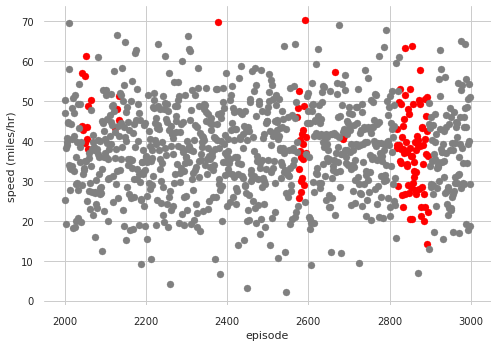

In [27]:
print('Total number of episodes:',data_test['Episode'].shape[0])
start=2000;
end=3000

fig, ax = plt.subplots()
episode=np.array(data_test['Episode'].values.tolist()[start:end])
test=np.array(data_test['test'].values.tolist()[start:end])
speed=np.array(data_test['Kick_Speed'].values.tolist()[start:end])

indices = test == 0
print('Number of Pass:',indices.sum())
print('Number of fail:',indices.shape[0]-indices.sum())

# normal values
ax.scatter(episode[~indices], speed[~indices], c = 'red',label='fail')
# bad values
ax.scatter(episode[indices], speed[indices], c = 'grey',label='Pass')
#ax.legend()
#ax.set_ylim([0,75])
plt.xlabel('episode')
plt.ylabel('speed (miles/hr)')
ax.grid(True) 
plt.show()

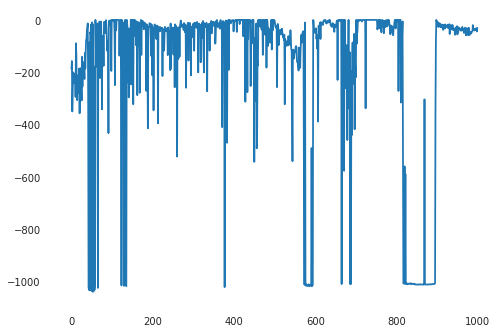

In [28]:
plt.plot(data_test["Rewards"].values.tolist()[start:end])

Failures:  [0, 1, 2, 1, 4, 2, 0, 3, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 4, 0, 1, 0, 20, 3, 0, 76, 0]


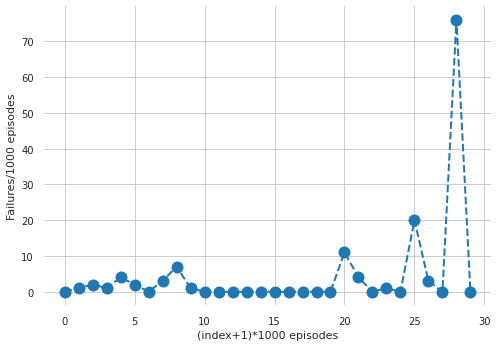

In [29]:
step=100
range_f=end/step
failure=[]
fig, ax = plt.subplots()
for i in range(int(range_f)):
    start=step*i
    episode=np.array(data_test['Episode'].values.tolist()[start:start+step])
    test=np.array(data_test['test'].values.tolist()[start:start+step])
    indices = test == 1
    failure.append(indices.sum())
print('Failures: ',failure)
ax.plot(failure,marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.xlabel('(index+1)*1000 episodes')
plt.ylabel('Failures/1000 episodes')
ax.grid(True) 
plt.show()   

In [30]:
#data for AVF training:
iteration_start=2000
iteration_end=3000
data=data_test[["Episode", "Kick_Speed","test"]][iteration_start:iteration_end]
std=np.std(data[["Episode", "Kick_Speed"]].values,axis=0)
mean=np.mean(data[["Episode", "Kick_Speed"]].values,axis=0)
np.savez('stdmean.npz',std=std, mean=mean)
data[["Episode", "Kick_Speed"]]=np.divide(np.subtract(data[["Episode", "Kick_Speed"]],mean),std)
print('std is:',std)
print('Mean is:',mean)
data.head()

std is: [288.67499026  11.1925538 ]
Mean is: [2499.5       37.81774]


,Episode,Kick_Speed,test
2000,-1.730320,0.817710,0.0
2001,-1.726856,1.110762,0.0
2002,-1.723391,-1.119292,0.0
2003,-1.719927,-1.664298,0.0
2004,-1.716463,0.030579,0.0


In [31]:
#AVF Training 
X=data[["Episode","Kick_Speed"]].values
print(X.shape)
Y=data["test"]
print(Y.shape)
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

#test train split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X[1,:].shape)

#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.997):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Model

model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(2,)), 
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid )
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=500, batch_size=8, callbacks=[callbacks]) ;


(1000, 2)
(1000,)
(2,)
Epoch 1/500
84/84 [==============================] - 0s 2ms/step - loss: 0.5281 - accuracy: 0.7955
Epoch 2/500
84/84 [==============================] - 0s 2ms/step - loss: 0.3680 - accuracy: 0.8776
Epoch 3/500
84/84 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8776
Epoch 4/500
84/84 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8776
Epoch 5/500
84/84 [==============================] - 0s 2ms/step - loss: 0.3390 - accuracy: 0.8776
Epoch 6/500
84/84 [==============================] - 0s 2ms/step - loss: 0.3351 - accuracy: 0.8776
Epoch 7/500
84/84 [==============================] - 0s 2ms/step - loss: 0.3307 - accuracy: 0.8776
Epoch 8/500
84/84 [==============================] - 0s 2ms/step - loss: 0.3255 - accuracy: 0.8776
Epoch 9/500
84/84 [==============================] - 0s 2ms/step - loss: 0.3220 - accuracy: 0.8776
Epoch 10/500
84/84 [==============================] - 0s 2ms/step - loss: 0.3193 - acc

84/84 [==============================] - 0s 2ms/step - loss: 0.1652 - accuracy: 0.9582
Epoch 83/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1668 - accuracy: 0.9478
Epoch 84/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1640 - accuracy: 0.9507
Epoch 85/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1642 - accuracy: 0.9507
Epoch 86/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1681 - accuracy: 0.9478
Epoch 87/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1617 - accuracy: 0.9552
Epoch 88/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1605 - accuracy: 0.9522
Epoch 89/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1590 - accuracy: 0.9537
Epoch 90/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1556 - accuracy: 0.9552
Epoch 91/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1533 - accuracy: 0.9582
Epoch 92/500


84/84 [==============================] - 0s 2ms/step - loss: 0.1201 - accuracy: 0.9582
Epoch 164/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1195 - accuracy: 0.9582
Epoch 165/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1206 - accuracy: 0.9567
Epoch 166/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1173 - accuracy: 0.9552
Epoch 167/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1233 - accuracy: 0.9522
Epoch 168/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1186 - accuracy: 0.9582
Epoch 169/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1179 - accuracy: 0.9582
Epoch 170/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1161 - accuracy: 0.9582
Epoch 171/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1181 - accuracy: 0.9567
Epoch 172/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1164 - accuracy: 0.9597
Epoc

84/84 [==============================] - 0s 2ms/step - loss: 0.1083 - accuracy: 0.9567
Epoch 245/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.9612
Epoch 246/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.9567
Epoch 247/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1097 - accuracy: 0.9567
Epoch 248/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1094 - accuracy: 0.9612
Epoch 249/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1001 - accuracy: 0.9627
Epoch 250/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.9522
Epoch 251/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1033 - accuracy: 0.9612
Epoch 252/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1035 - accuracy: 0.9612
Epoch 253/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1112 - accuracy: 0.9552
Epoc

84/84 [==============================] - 0s 2ms/step - loss: 0.0964 - accuracy: 0.9642
Epoch 326/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1057 - accuracy: 0.9597
Epoch 327/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0981 - accuracy: 0.9597
Epoch 328/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1070 - accuracy: 0.9627
Epoch 329/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0965 - accuracy: 0.9642
Epoch 330/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0958 - accuracy: 0.9627
Epoch 331/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.9657
Epoch 332/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1015 - accuracy: 0.9597
Epoch 333/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1035 - accuracy: 0.9612
Epoch 334/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0981 - accuracy: 0.9657
Epoc

84/84 [==============================] - 0s 2ms/step - loss: 0.1004 - accuracy: 0.9612
Epoch 407/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0904 - accuracy: 0.9701
Epoch 408/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0923 - accuracy: 0.9701
Epoch 409/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0979 - accuracy: 0.9672
Epoch 410/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9672
Epoch 411/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9716
Epoch 412/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0984 - accuracy: 0.9672
Epoch 413/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0946 - accuracy: 0.9701
Epoch 414/500
84/84 [==============================] - 0s 2ms/step - loss: 0.1014 - accuracy: 0.9612
Epoch 415/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0961 - accuracy: 0.9642
Epoc

84/84 [==============================] - 0s 2ms/step - loss: 0.0956 - accuracy: 0.9657
Epoch 488/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0929 - accuracy: 0.9687
Epoch 489/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0941 - accuracy: 0.9672
Epoch 490/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.9657
Epoch 491/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0976 - accuracy: 0.9687
Epoch 492/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0961 - accuracy: 0.9642
Epoch 493/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0947 - accuracy: 0.9687
Epoch 494/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0869 - accuracy: 0.9687
Epoch 495/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0874 - accuracy: 0.9687
Epoch 496/500
84/84 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9672
Epoc

In [32]:
results = model.evaluate(x_test, y_test, batch_size=16)
print('test loss, test acc:', results)

21/21 [==============================] - 0s 611us/step - loss: 0.2557 - accuracy: 0.9394
test loss, test acc: [0.25570276379585266, 0.939393937587738]


In [33]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


# Running Dummy adversary search for model testing purpose only

In [34]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	saved_model.pb	variables


In [35]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [36]:
samples_per_iteration=2000
random_seed=np.random.randint(1,10000)
np.random.seed(random_seed)
candidate_initial_speed=[]
for i in range(samples_per_iteration): 
    #candidate_initial_speed =(9* np.random.randn(samples_per_iteration, 1) + 38).reshape(-1,1)
    candidate_initial_speed.append(np.random.normal(38,11))

candidate_initial_speed=np.array(candidate_initial_speed).reshape(-1,1)
Episode=3000*np.ones((samples_per_iteration,1)).reshape(-1,1)

data=np.concatenate((Episode,candidate_initial_speed),axis=1)
print(data.shape)
print('Data :',data)

container = np.load('stdmean.npz')
data_normalised=np.divide(np.subtract(data,container['mean']),container['std'])
#plt.plot(candidate_initial_speed)

(2000, 2)
Data : [[3000.           40.87405318]
 [3000.           37.58694933]
 [3000.           33.05073439]
 ...
 [3000.           43.36763148]
 [3000.           50.3944245 ]
 [3000.           50.62635822]]


In [37]:
predicted_y=new_model.predict(data_normalised,batch_size=8)
max_value=np.amax(predicted_y)
print(max_value)
print(predicted_y.shape)
array_position=np.where(predicted_y==max_value)[0]
print(array_position)
#print(predicted_y)
#print(np.sort(predicted_y, axis=None) )
data_final=np.concatenate((data[array_position,:],predicted_y[array_position,:]),axis=1)
print(data_final)

2.0503656e-14
(2000, 1)
[36]
[[3.00000000e+03 7.10640716e+01 2.05036556e-14]]


In [38]:
data_final[0][1]

71.06407158782739